# The thinking behind this code
I'd like to visualize the Total Spacecraft Bus Current data (the second of five datasets in my study) and then detect point outliers in it using simple statistics. Specifically, I'll call points outliers if they lie outside some number of standard deviations away from either the mean or a rolling mean with a fixed window. I'll explore the different results given by each mean, and how adjusting the number of standard deviations or the window's size affects the results.


In [4]:
# Standard modules
import datetime
import progressbar
import pandas as pd
import numpy as np
from matplotlib import pyplot
from pandas import datetime
from pandas import read_csv

## First thing's first: load the Total Spacecraft Bus Current data into a pandas Series

count    5345.000000
mean       11.000077
std         1.714431
min         0.000000
25%        11.043905
50%        11.503601
75%        11.861583
max        12.714043
Name: 11.799583419700312, dtype: float64


2004-02-13
2004-02-14    11.826283
2004-02-15    11.804309
2004-02-16    11.803606
2004-02-17    11.239218
2004-02-18    11.810166
Name: 11.799583419700312, dtype: float64


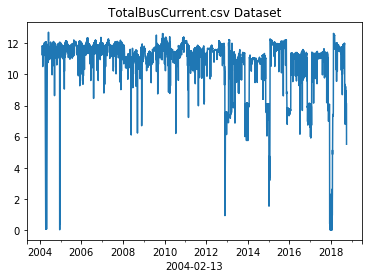

In [6]:
def parser(x):
    new_time = ''.join(x.split('.')[0])  # remove microseconds
    return datetime.strptime(new_time, '%Y-%m-%d') 


# Load the dataset
dataset_path = 'Data/TotalBusCurrent.csv'
time_series = read_csv(dataset_path, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

print(time_series.describe())
print('\n')
print(time_series.head())
time_series.plot(title=dataset_path.split('/')[-1] + ' Dataset')  # plots the data
pyplot.show()    


## Next, let's see what 2 std's from the dataset's mean gives us

In [7]:
def detect_anomalies_with_mean(ts, num_stds, verbose, var_name='Value'):
    # Gather statistics in preparation for outlier detection
    mean = float(ts.values.mean())
    mean_line = pd.Series(([mean] * len(ts)), index=ts.index)
    std = float(ts.values.std(ddof=0))
    X = ts.values
    outliers = pd.Series()
    time_series_with_outliers = pd.DataFrame({var_name: ts})
    time_series_with_outliers['Outlier'] = 'False'

    if verbose:
        pyplot.plot(ts, color='blue', label='Time Series')
        pyplot.plot(mean_line, color='black', label='Time Series Mean')
        pyplot.legend(loc='best')
        pyplot.title('Time Series & Mean')
        pyplot.show()

    # Label outliers using standard deviation
    for t in range(len(X)):
        obs = X[t]
        if abs(mean-obs) > std*num_stds:
            time_series_with_outliers.at[ts.index[t], 'Outlier'] = 'True'
            outlier = pd.Series(obs, index=[ts.index[t]])
            outliers = outliers.append(outlier)

    return time_series_with_outliers, outliers


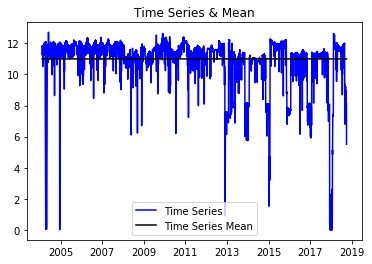


Detected Outliers: 221



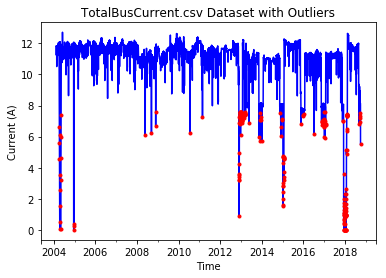

In [8]:
time_series_with_outliers, outliers = detect_anomalies_with_mean(time_series, 
                                                                 num_stds=2, verbose=True,
                                                                 var_name='Current')

# Plot the outliers
time_series.plot(color='blue', title=dataset_path.split('/')[-1] + ' Dataset with Outliers')
pyplot.xlabel('Time')
pyplot.ylabel('Current (A)')
if len(outliers) > 0:
    print('\nDetected Outliers: ' + str(len(outliers)) + "\n")
    outliers.plot(color='red', style='.')
pyplot.show()

## As expected, every point that lies far enough below the mean line has now been labeled an outlier.

If we wanted to detect the lowest dips in the data, this didn't do an awful job. But note that many dips slipped by. We could adjust the threshold between normal and outlier by changing the number of standard deviations used. A larger number will detect fewer outliers, while a smaller number will detect more of them. Doubling the number of standard deviations in this case will simply redefine "far enough below" to a lower value, and thus only detect even lower dips:


Detected Outliers: 76



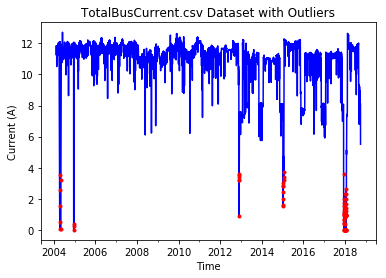

In [9]:
time_series_with_outliers, outliers = detect_anomalies_with_mean(time_series, 
                                                                 num_stds=4, verbose=False,
                                                                 var_name='Current')

# Plot the outliers
time_series.plot(color='blue', title=dataset_path.split('/')[-1] + ' Dataset with Outliers')
pyplot.xlabel('Time')
pyplot.ylabel('Current (A)')
if len(outliers) > 0:
    print('\nDetected Outliers: ' + str(len(outliers)) + "\n")
    outliers.plot(color='red', style='.')
pyplot.show()

## Next, let's try a rolling mean with a window of 500 samples

In [13]:
def detect_anomalies_with_rolling_mean(ts, num_stds, window, verbose, var_name='Value'):
    if window <= 0:
        raise ValueError('\'window\' must be given a value greater than 0 when using rolling mean.')
    else:
        # Gather statistics in preparation for outlier detection
        rolling_mean = ts.rolling(window=window, center=False).mean()
        first_window_mean = ts.iloc[:window].mean()
        for i in range(window):  # fill first 'window' samples with mean of those samples
            rolling_mean[i] = first_window_mean
        std = float(ts.values.std(ddof=0))
        X = ts.values
        outliers = pd.Series()
        time_series_with_outliers = pd.DataFrame({var_name: ts})
        time_series_with_outliers['Outlier'] = 'False'

        if verbose:
            pyplot.plot(ts, color='blue', label='Time Series')
            pyplot.plot(rolling_mean, color='black', label='Rolling Mean')
            pyplot.legend(loc='best')
            pyplot.title('Time Series & Rolling Mean')
            pyplot.show()

        # Label outliers using standard deviation
        for t in range(len(X)):
            obs = X[t]
            y = rolling_mean[t]
            if abs(y-obs) > std*num_stds:
                time_series_with_outliers.at[ts.index[t], 'Outlier'] = 'True'
                outlier = pd.Series(obs, index=[ts.index[t]])
                outliers = outliers.append(outlier)

        return time_series_with_outliers, outliers


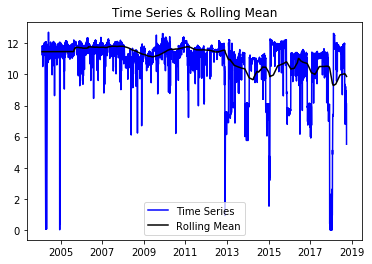


Detected Outliers: 190



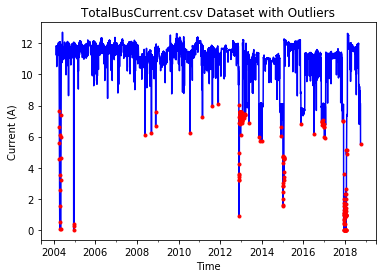

In [14]:
time_series_with_outliers, outliers = detect_anomalies_with_rolling_mean(time_series, 
                                                                         num_stds=2, 
                                                                         window=500, 
                                                                         verbose=True)

# Plot the outliers
time_series.plot(color='blue', title=dataset_path.split('/')[-1] + ' Dataset with Outliers')
pyplot.xlabel('Time')
pyplot.ylabel('Current (A)')
if len(outliers) > 0:
    print('\nDetected Outliers: ' + str(len(outliers)) + "\n")
    outliers.plot(color='red', style='.')
pyplot.show()

## Here we can see how a rolling mean might be a step up from a flat mean. 

The rolling mean fits the data much better than the flat mean. But selecting a useful window size is critical. One that's too large starts to look like the flat mean, and too small overfits the data. (A window of the dataset's length will be the flat mean, and a window of 1 will be the original curve.) Let's see what overfitting does by changing the window from 500 to 5:

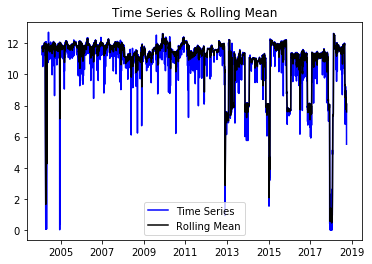


Detected Outliers: 26



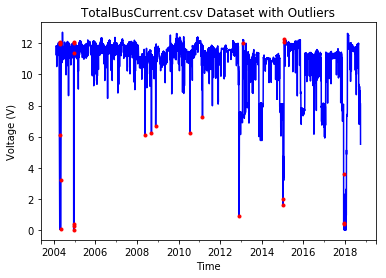

In [18]:
time_series_with_outliers, outliers = detect_anomalies_with_rolling_mean(time_series, 
                                                                         num_stds=2, 
                                                                         window=5, 
                                                                         verbose=True)

# Plot the outliers
time_series.plot(color='blue', title=dataset_path.split('/')[-1] + ' Dataset with Outliers')
pyplot.xlabel('Time')
pyplot.ylabel('Voltage (V)')
if len(outliers) > 0:
    print('\nDetected Outliers: ' + str(len(outliers)) + "\n")
    outliers.plot(color='red', style='.')
pyplot.show()

## There are now significantly fewer outliers labeled, because the rolling mean is nearly the original curve. 
This now seems to have basically detected only the very lowest and most sudden dips in the data, with the exception of a few points up top due to the mean itself dipping low. This could be good or bad, depending on what you wanted to find (i.e., what you want to consider an outlier). The statistical methods explored here are simplistic, but they could be useful depending on what you want from them. It's important to consider them before trying more complicated methods. If this doesn't cut it, diagnose what's wrong/missing and then maybe try something more advanced.